# Chapter 11: Training Deep Neural Networks

In [1]:
import tensorflow as tf
import numpy as np
from time import strftime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

1. Glorot & He initialization aims to solve the problem of unstable gradients in backpropagation. It does this by ensuring that the variance of the inputs and outputs of each layer remains roughly constant as information flows forwards & backwards through the network.
2. It is not OK to initialize all weights with the same value, even if this value is selected via He initialization. All neurons would be identical & the will remain identical, your model would act as if it had one neuron per layer and likely underfit the data.
3. It is OK to initialize the bias terms to 0, as long as the symmetry is broken by properly initializing the weights.
4. Which activation function to use & when:
    * ReLU: good default for simple tasks
    * Swish: better default for complex tasks (try parametrized Swish by making $\beta$ learnable for the most complex tasks)
    * Mish: may give better results than Swish but uses more compute
    * Leaky ReLU: if runtime latency is important (like swish, making the negative slope learnable improves performance on more complex tasks)
    * SELU: for deep MLPs (respect the constraints to ensure self normalization)

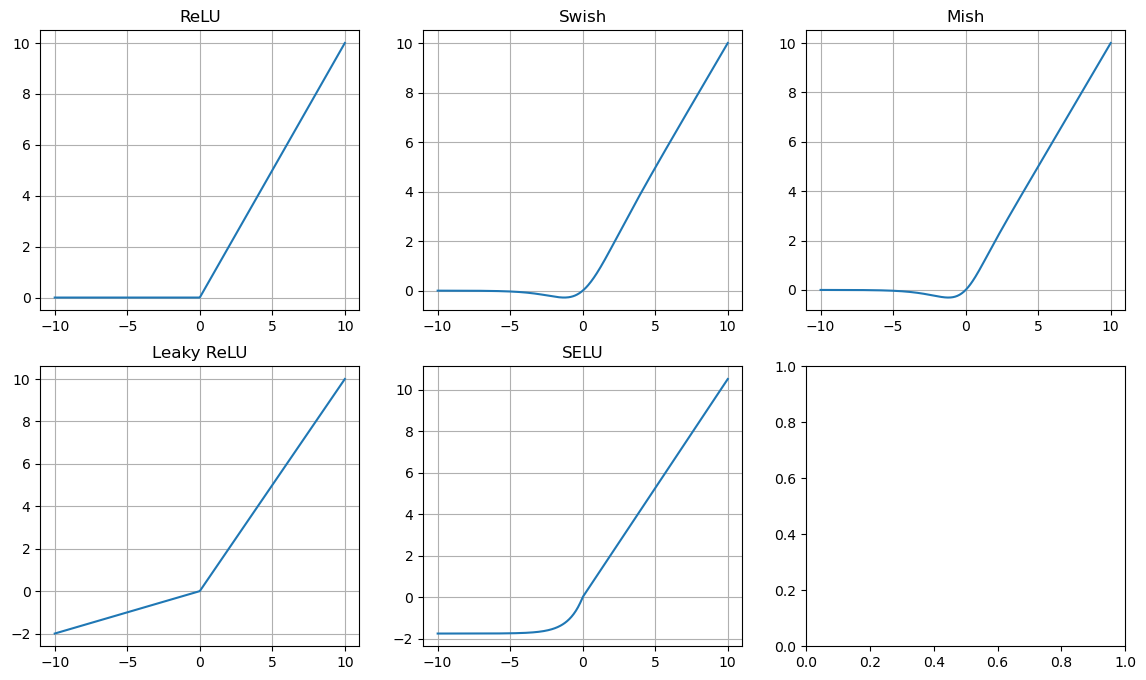

In [2]:
activations = {
    "ReLU": tf.keras.activations.relu,
    "Swish": tf.keras.activations.swish,
    "Mish": tf.keras.activations.mish,
    "Leaky ReLU": lambda x: tf.keras.activations.leaky_relu(x, negative_slope=0.2),
    "SELU": tf.keras.activations.selu,
}

fig, axs = plt.subplots(
    np.ceil(len(activations) / 3).astype(int),
    min(len(activations), 3),
    figsize=(14, 4 * np.ceil(len(activations) / 3).astype(int)),
)

x = np.linspace(-10, 10, 400)
for ax, (func_name, func) in zip(axs.flatten(), activations.items()):
    ax.plot(x, func(x))
    ax.set_title(func_name)
    ax.grid(True)

plt.show()

5. If you set momentum too close to 1 when using the `tf.keras.optimizers.SGD` optimizer, your model will likely take longer to train because the optimizer will overshoot the global optima and oscillate around quite a bit.
6. Three ways to produce a sparse model, i.e. where many of the weights are 0:
    * zero out small weights,
    * strong l1 normalization,
    * use the TensorFlow Model Optimization Toolkit.
7. Dropout does slow down training, however inference will be just as quick as before. However, if you use Monte Carlo (MC) Dropout (i.e. keeping dropout active during inference and taking the average of many predictions), then inference will be slowed down.

## 8. Training a DNN on the CIFAR10 image dataset

### 8.a. Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the Swish activation function.

In [3]:
def make_model(X_train, batch_norm=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=[32, 32, 3]))

    norm_layer = tf.keras.layers.Normalization()
    norm_layer.adapt(X_train)
    model.add(norm_layer)

    model.add(tf.keras.layers.Flatten())

    for _ in range(20):
        model.add(
            tf.keras.layers.Dense(
                100,
                kernel_initializer="he_normal",
                use_bias=not batch_norm,
            )
        )
        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation("swish"))

    model.add(
        tf.keras.layers.Dense(
            10,
            activation="softmax",
            kernel_initializer="glorot_uniform",
        )
    )

    return model

### 8.b. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_ data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10_000)
class_names = (
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

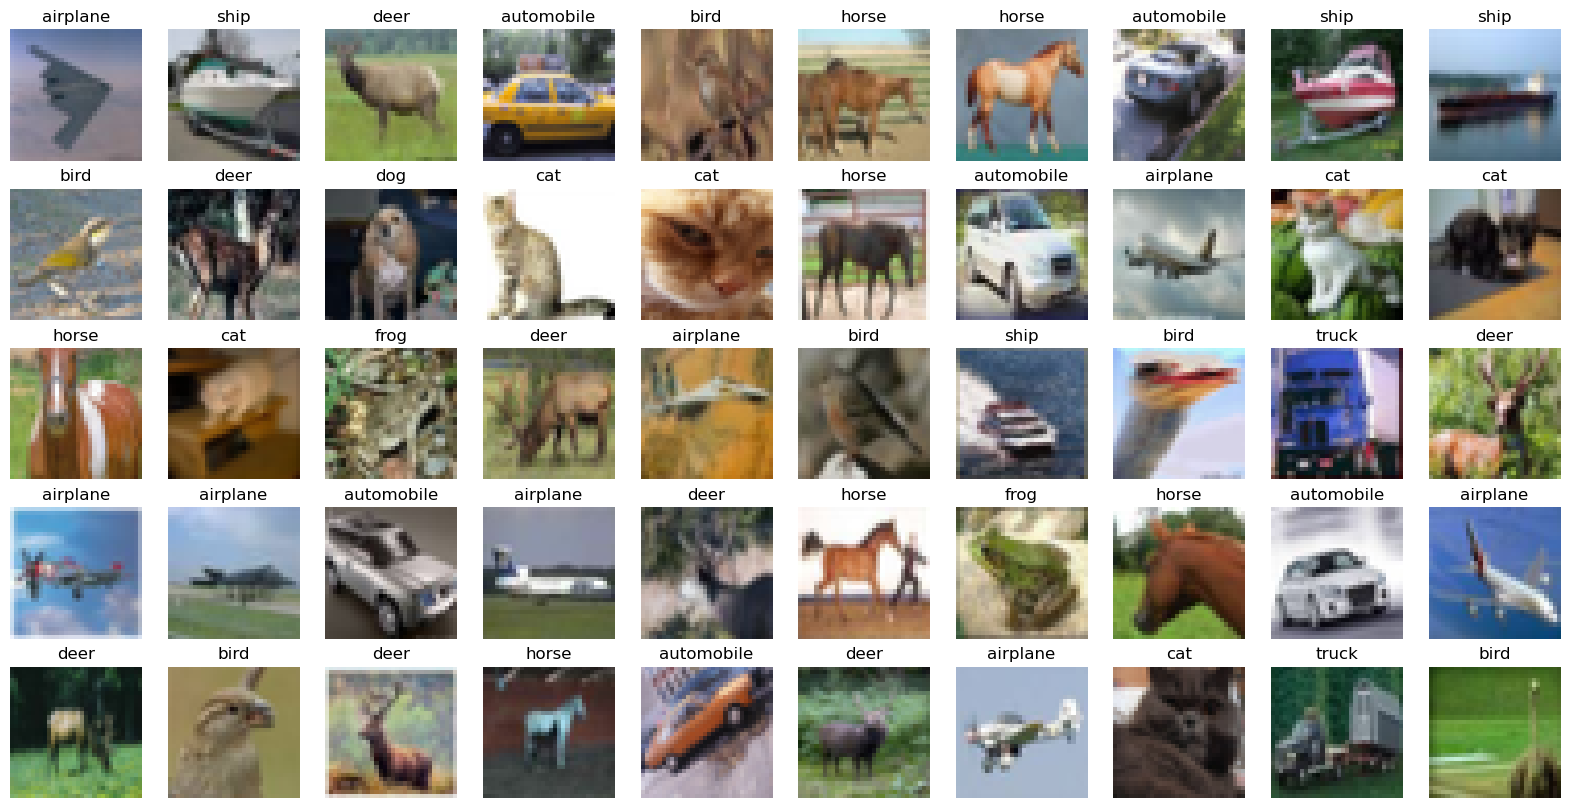

In [5]:
fig, axs = plt.subplots(5, 10, figsize=(20, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train[i])
    ax.set_title(class_names[y_train[i, 0]])
    ax.axis("off")

In [6]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, starting_lr, end_lr, n_iter):
        self.factor = (end_lr / starting_lr) ** (1 / n_iter)
        self.starting_lr = starting_lr
        self.end_lr = end_lr
        self.learning_rates = []
        self.losses = []

    def on_train_begin(self, logs=None):
        self.model.optimizer.learning_rate = self.starting_lr

    def on_train_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        if lr > self.end_lr:
            print(
                "\nReached end learning rate, stopping training",
                f"Learning rate of minimum loss: {self.learning_rates[np.argmin(self.losses)]}",
                sep="\n",
            )
            self.model.stop_training = True

        self.model.optimizer.learning_rate = lr
        self.learning_rates.append(lr)
        self.losses.append(logs["loss"])


def plot_lr_loss(exponential__learning_rate_cb, y_max=2.5):
    fig, ax = plt.subplots()

    ax.plot(
        exponential__learning_rate_cb.learning_rates,
        exponential__learning_rate_cb.losses,
    )
    ax.set_xscale("log")
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Loss")
    ax.set_ylim(min(exponential__learning_rate_cb.losses) * 0.99, y_max)
    ax.grid(True)

    plt.show()


Reached end learning rate, stopping training
Learning rate of minimum loss: 0.0001783203034593245


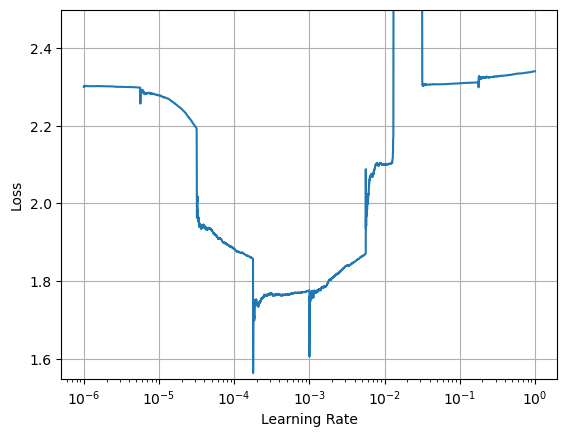

In [7]:
compile_kwargs = {
    "loss": "sparse_categorical_crossentropy",
    "metrics": ["accuracy"],
}


def exp_lr_fit_kwargs():
    global exponential__learning_rate_cb
    exponential__learning_rate_cb = ExponentialLearningRate(1e-6, 1e0, 10_000)
    return {
        "validation_data": (X_val, y_val),
        "verbose": 0,
        "epochs": 10,
        "callbacks": [exponential__learning_rate_cb],
    }


model = make_model(X_train)
model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    **compile_kwargs,
)
model.fit(X_train, y_train, **exp_lr_fit_kwargs())

plot_lr_loss(exponential__learning_rate_cb)

In [8]:
def fit_kwargs():
    return {
    "validation_data": (X_val, y_val),
    "verbose": 0,
    "epochs":100,
    "callbacks":[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.TensorBoard(f"models/TensorBoard/11/{strftime("run_%Y_%m_%d_%H_%M_%S")}")
    ],
}

model = make_model(X_train)
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4 / 2),
    **compile_kwargs,
)
model.fit(X_train, y_train, **fit_kwargs())
model.evaluate(X_val, y_val)

Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4444 - loss: 1.5614


[1.5799638032913208, 0.43860000371932983]

### 8.c. Now try adding batch normalization and compare the learning curves: is it converging faster than before? Does it produce a better model? How does it affect training speed?


Reached end learning rate, stopping training
Learning rate of minimum loss: 0.001001383486010349


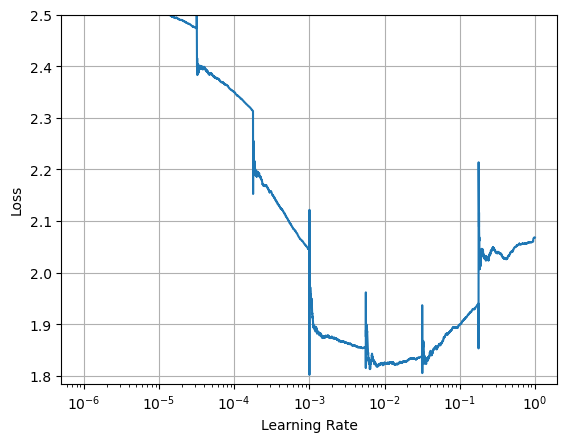

In [9]:
model = make_model(X_train, batch_norm=True)
model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    **compile_kwargs,
)
model.fit(X_train, y_train, **exp_lr_fit_kwargs())

plot_lr_loss(exponential__learning_rate_cb)

In [10]:
model = make_model(X_train, batch_norm=True)
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=4e-3 / 2),
    **compile_kwargs,
)
model.fit(X_train, y_train, **fit_kwargs())
model.evaluate(X_val, y_val)

Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 17.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5178 - loss: 1.3732


[1.3838320970535278, 0.5188000202178955]

The model took longer to train but converged to a more accurate model.

### 8.d. Try replacing batch normalization with SELU, and make the necessary adjustments to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).

In [11]:
def make_model_selu(X_train, dropout=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=[32, 32, 3]))
    norm_layer = tf.keras.layers.Normalization()
    norm_layer.adapt(X_train)
    model.add(norm_layer)
    model.add(tf.keras.layers.Flatten())

    for _ in range(20):
        model.add(
            tf.keras.layers.Dense(
                100,
                kernel_initializer="lecun_normal",
                activation="selu",
            )
        )

    if dropout:
        model.add(tf.keras.layers.AlphaDropout(0.1))

    model.add(
        tf.keras.layers.Dense(
            10,
            activation="softmax",
            kernel_initializer="glorot_uniform",
        )
    )

    return model


Reached end learning rate, stopping training
Learning rate of minimum loss: 0.00017955636161502678


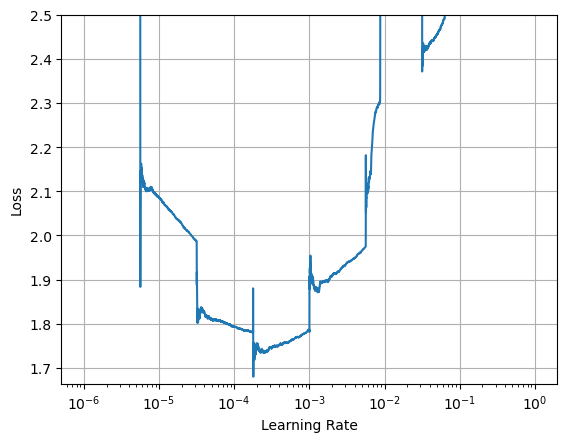

In [12]:
model = make_model_selu(X_train)
model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    **compile_kwargs,
)
model.fit(X_train, y_train, **exp_lr_fit_kwargs())

plot_lr_loss(exponential__learning_rate_cb)

In [13]:
model = make_model_selu(X_train)
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4 / 2),
    **compile_kwargs,
)
model.fit(X_train, y_train, **fit_kwargs())
model.evaluate(X_val, y_val)

Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4754 - loss: 1.5271


[1.5399972200393677, 0.4674000144004822]

The SELU model didn't perform as well as the batch normalization model, or even the regular swish model.

### 8.e. Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC dropout.


Reached end learning rate, stopping training
Learning rate of minimum loss: 0.001001383486010349


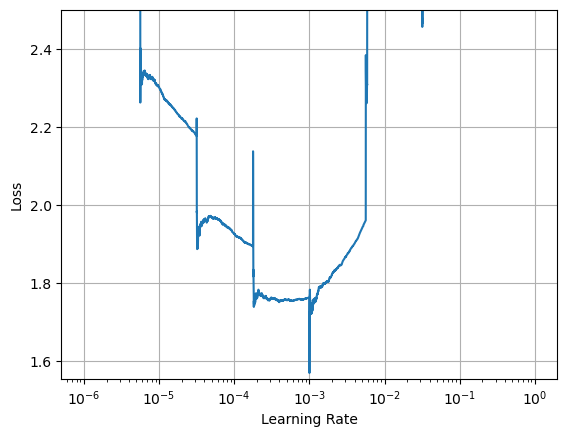

In [14]:
model = make_model_selu(X_train, dropout=True)
model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    **compile_kwargs,
)
model.fit(X_train, y_train, **exp_lr_fit_kwargs())

plot_lr_loss(exponential__learning_rate_cb)

In [15]:
model = make_model_selu(X_train, dropout=True)
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4 / 2),
    **compile_kwargs,
)
model.fit(X_train, y_train, **fit_kwargs())
model.evaluate(X_val, y_val)

Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4799 - loss: 1.5607


[1.5825161933898926, 0.46959999203681946]

The model with an `AlphaDropout` model did just about as well as the plain SELU model. Now lets try MC dropout.

In [16]:
class MCAlphaDropout(tf.keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)


mc_model = tf.keras.Sequential(
    [
        (
            MCAlphaDropout(0.1)
            if isinstance(layer, tf.keras.layers.AlphaDropout)
            else layer
        )
        for layer in model.layers
    ]
)

y_probas = np.mean(
    [mc_model.predict(X_val, verbose=0) for sample in range(100)], axis=0
)
y_pred = np.argmax(y_probas, axis=1)
accuracy = np.mean(y_pred == y_val[:, 0])
print(f"Accuracy: {accuracy:.3%}")

Accuracy: 47.090%


This gave marginally better accuracy.

### 8.f. Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

len: 1250, max: 1.0, min: 0.001


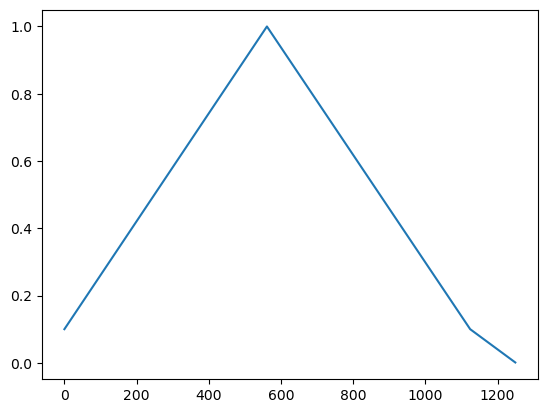

In [17]:
def one_cycle_lrs(
    epoch_n_iter,
    max_lr,
    min_lr=None,
):
    if min_lr is None:
        min_lr = max_lr / 10

    return np.concatenate(
        [
            np.linspace(min_lr, max_lr, int(np.floor(0.45 * epoch_n_iter))),
            np.linspace(max_lr, min_lr, int(np.ceil(0.45 * epoch_n_iter) + 1))[1:],
            np.linspace(min_lr, min_lr / 100, int(0.1 * epoch_n_iter) + 1)[1:],
        ]
    )


lrs = one_cycle_lrs(1_250, 1)
print(f"len: {len(lrs)}, max: {max(lrs)}, min: {min(lrs)}")
plt.plot(lrs)
plt.show()

In [18]:
class OneCycleLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, epoch_n_iter, max_lr, min_lr=None):
        self.learning_rates = one_cycle_lrs(epoch_n_iter, max_lr, min_lr)

    def on_train_batch_begin(self, batch, logs=None):
        self.model.optimizer.learning_rate = self.learning_rates[batch]

In [19]:
model = make_model_selu(X_train, dropout=True)

model.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    **compile_kwargs,
)

one_cycle_fit_kwargs = fit_kwargs()
one_cycle_fit_kwargs["callbacks"].append(
        tf.keras.callbacks.TensorBoard(f"models/TensorBoard/11/{strftime("run_%Y_%m_%d_%H_%M_%S")}")
)

model.fit(X_train, y_train, **one_cycle_fit_kwargs)
model.evaluate(X_val, y_val)

Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4391 - loss: 1.5732


[1.587283730506897, 0.4325000047683716]

This 1cycle took one less epoch to train but didn't improve performance. The best model is still the batch normalization model.